# Lesson 72: Model Serving and REST APIs

## Introduction

Welcome to Day 72 of the 100 Days of Machine Learning! Today, we explore one of the most crucial aspects of MLOps: **model serving**. After spending weeks building, training, and validating machine learning models, the next critical step is making these models accessible to end-users and applications.

In this lesson, you will learn:
- The fundamentals of model serving and deployment architectures
- How to create REST APIs for machine learning models using Flask and FastAPI
- The difference between batch and real-time inference
- Best practices for model serving in production environments
- Performance considerations and optimization strategies

By the end of this lesson, you'll be able to deploy your trained models as scalable REST APIs that can serve predictions to web applications, mobile apps, and other services.

## Theory: Model Serving Fundamentals

### What is Model Serving?

**Model serving** is the process of making a trained machine learning model available for making predictions on new data. It bridges the gap between model development and practical application.

### Inference Types

There are two primary types of inference:

1. **Real-time (Online) Inference**: Predictions are made immediately upon request, typically with low latency requirements (milliseconds to seconds).

2. **Batch Inference**: Predictions are made on large datasets at scheduled intervals (e.g., daily, hourly).

### Mathematical Foundation: Prediction Inference

For a trained model $f(\mathbf{x}; \theta)$ with parameters $\theta$, the inference process computes:

$$
\hat{y} = f(\mathbf{x}_{new}; \theta^*)
$$

where:
- $\mathbf{x}_{new}$ is the new input data
- $\theta^*$ are the learned (fixed) parameters
- $\hat{y}$ is the predicted output

### Batch vs. Real-time Scoring

**Batch Scoring** processes multiple inputs simultaneously:

$$
\hat{\mathbf{Y}} = f(\mathbf{X}; \theta^*) = \begin{bmatrix} f(\mathbf{x}_1; \theta^*) \\ f(\mathbf{x}_2; \theta^*) \\ \vdots \\ f(\mathbf{x}_n; \theta^*) \end{bmatrix}
$$

**Real-time Scoring** processes single requests with latency constraints:

$$
\text{Latency} = t_{network} + t_{preprocessing} + t_{inference} + t_{postprocessing}
$$

where:
- $t_{network}$: Network transmission time
- $t_{preprocessing}$: Input data transformation time
- $t_{inference}$: Model computation time
- $t_{postprocessing}$: Output formatting time

### REST API Architecture

REST (Representational State Transfer) APIs provide a standardized way to expose model functionality:

- **Stateless**: Each request contains all necessary information
- **HTTP Methods**: GET (retrieve), POST (create/predict), PUT (update), DELETE (remove)
- **JSON Format**: Common data interchange format for requests and responses

## Python Implementation

Let's implement model serving using both Flask and FastAPI frameworks. We'll start by training a simple model and then create APIs to serve it.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import json
import time

print("Libraries imported successfully!")

Libraries imported successfully!


### Step 1: Train and Save a Model

First, we'll train a simple classifier on the Iris dataset and save it for serving.

In [2]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_names}")
print(f"Target classes: {target_names}")

Dataset shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target classes: ['setosa' 'versicolor' 'virginica']


In [3]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model trained successfully!")
print(f"Accuracy on test set: {accuracy:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred, target_names=target_names)}")

Model trained successfully!
Accuracy on test set: 1.0000

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [4]:
# Save the trained model
model_path = 'iris_model.pkl'
joblib.dump(model, model_path)
print(f"Model saved to {model_path}")

# Also save metadata
metadata = {
    'feature_names': feature_names,
    'target_names': target_names.tolist(),
    'model_type': 'RandomForestClassifier',
    'accuracy': float(accuracy)
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("Metadata saved successfully!")

Model saved to iris_model.pkl
Metadata saved successfully!


### Step 2: Flask API Implementation

Flask is a lightweight web framework perfect for creating simple REST APIs. Here's how to create a model serving API with Flask.

In [5]:
# Flask API code (this would run in a separate script)
flask_code = '''
from flask import Flask, request, jsonify
import joblib
import numpy as np
import json

app = Flask(__name__)

# Load model and metadata at startup
model = joblib.load('iris_model.pkl')
with open('model_metadata.json', 'r') as f:
    metadata = json.load(f)

@app.route('/health', methods=['GET'])
def health_check():
    """Health check endpoint"""
    return jsonify({'status': 'healthy', 'model': metadata['model_type']})

@app.route('/predict', methods=['POST'])
def predict():
    """Single prediction endpoint"""
    try:
        # Get input data from request
        data = request.get_json()
        features = np.array(data['features']).reshape(1, -1)
        
        # Make prediction
        prediction = model.predict(features)[0]
        probability = model.predict_proba(features)[0]
        
        # Format response
        response = {
            'prediction': metadata['target_names'][prediction],
            'prediction_id': int(prediction),
            'probabilities': {
                name: float(prob) 
                for name, prob in zip(metadata['target_names'], probability)
            }
        }
        return jsonify(response)
    
    except Exception as e:
        return jsonify({'error': str(e)}), 400

@app.route('/batch_predict', methods=['POST'])
def batch_predict():
    """Batch prediction endpoint"""
    try:
        data = request.get_json()
        features = np.array(data['features'])
        
        predictions = model.predict(features)
        probabilities = model.predict_proba(features)
        
        response = {
            'predictions': [
                {
                    'prediction': metadata['target_names'][pred],
                    'prediction_id': int(pred),
                    'probabilities': {
                        name: float(prob)
                        for name, prob in zip(metadata['target_names'], probs)
                    }
                }
                for pred, probs in zip(predictions, probabilities)
            ]
        }
        return jsonify(response)
    
    except Exception as e:
        return jsonify({'error': str(e)}), 400

@app.route('/model_info', methods=['GET'])
def model_info():
    """Get model metadata"""
    return jsonify(metadata)

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=False)
'''

# Save Flask app to file
with open('flask_app.py', 'w') as f:
    f.write(flask_code)

print("Flask API code saved to flask_app.py")
print("\nFlask API Endpoints:")
print("  - GET  /health          : Health check")
print("  - POST /predict         : Single prediction")
print("  - POST /batch_predict   : Batch predictions")
print("  - GET  /model_info      : Model metadata")

Flask API code saved to flask_app.py

Flask API Endpoints:
  - GET  /health          : Health check
  - POST /predict         : Single prediction
  - POST /batch_predict   : Batch predictions
  - GET  /model_info      : Model metadata


### Step 3: FastAPI Implementation

FastAPI is a modern, high-performance framework with automatic API documentation, type checking, and async support.

In [6]:
# FastAPI code (this would run in a separate script)
fastapi_code = '''
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import List
import joblib
import numpy as np
import json
import uvicorn

app = FastAPI(title="Iris Model API", version="1.0")

# Load model and metadata at startup
model = joblib.load('iris_model.pkl')
with open('model_metadata.json', 'r') as f:
    metadata = json.load(f)

# Define request/response models
class PredictionInput(BaseModel):
    features: List[float]
    
    class Config:
        json_schema_extra = {
            "example": {
                "features": [5.1, 3.5, 1.4, 0.2]
            }
        }

class BatchPredictionInput(BaseModel):
    features: List[List[float]]
    
    class Config:
        json_schema_extra = {
            "example": {
                "features": [
                    [5.1, 3.5, 1.4, 0.2],
                    [6.2, 3.4, 5.4, 2.3]
                ]
            }
        }

class PredictionOutput(BaseModel):
    prediction: str
    prediction_id: int
    probabilities: dict

@app.get("/")
async def root():
    """Root endpoint with API information"""
    return {
        "message": "Iris Model API",
        "version": "1.0",
        "docs": "/docs"
    }

@app.get("/health")
async def health_check():
    """Health check endpoint"""
    return {"status": "healthy", "model": metadata["model_type"]}

@app.post("/predict", response_model=PredictionOutput)
async def predict(input_data: PredictionInput):
    """Single prediction endpoint with automatic validation"""
    try:
        features = np.array(input_data.features).reshape(1, -1)
        
        if features.shape[1] != 4:
            raise HTTPException(status_code=400, detail="Expected 4 features")
        
        prediction = model.predict(features)[0]
        probability = model.predict_proba(features)[0]
        
        return PredictionOutput(
            prediction=metadata["target_names"][prediction],
            prediction_id=int(prediction),
            probabilities={
                name: float(prob)
                for name, prob in zip(metadata["target_names"], probability)
            }
        )
    
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

@app.post("/batch_predict")
async def batch_predict(input_data: BatchPredictionInput):
    """Batch prediction endpoint"""
    try:
        features = np.array(input_data.features)
        
        if features.shape[1] != 4:
            raise HTTPException(status_code=400, detail="Expected 4 features per sample")
        
        predictions = model.predict(features)
        probabilities = model.predict_proba(features)
        
        return {
            "predictions": [
                {
                    "prediction": metadata["target_names"][pred],
                    "prediction_id": int(pred),
                    "probabilities": {
                        name: float(prob)
                        for name, prob in zip(metadata["target_names"], probs)
                    }
                }
                for pred, probs in zip(predictions, probabilities)
            ]
        }
    
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

@app.get("/model_info")
async def model_info():
    """Get model metadata"""
    return metadata

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)
'''

# Save FastAPI app to file
with open('fastapi_app.py', 'w') as f:
    f.write(fastapi_code)

print("FastAPI code saved to fastapi_app.py")
print("\nFastAPI Features:")
print("  - Automatic API documentation at /docs")
print("  - Input validation with Pydantic models")
print("  - Type hints and async support")
print("  - OpenAPI schema generation")
print("\nFastAPI Endpoints:")
print("  - GET  /              : Root information")
print("  - GET  /health        : Health check")
print("  - POST /predict       : Single prediction")
print("  - POST /batch_predict : Batch predictions")
print("  - GET  /model_info    : Model metadata")

FastAPI code saved to fastapi_app.py

FastAPI Features:
  - Automatic API documentation at /docs
  - Input validation with Pydantic models
  - Type hints and async support
  - OpenAPI schema generation

FastAPI Endpoints:
  - GET  /              : Root information
  - GET  /health        : Health check
  - POST /predict       : Single prediction
  - POST /batch_predict : Batch predictions
  - GET  /model_info    : Model metadata


### Step 4: Testing API Requests

Let's simulate how clients would interact with our APIs.

In [7]:
# Simulate API request/response (without actually running the server)
def simulate_prediction(features):
    """Simulate single prediction"""
    features_array = np.array(features).reshape(1, -1)
    prediction = model.predict(features_array)[0]
    probability = model.predict_proba(features_array)[0]
    
    return {
        'prediction': target_names[prediction],
        'prediction_id': int(prediction),
        'probabilities': {
            name: float(prob)
            for name, prob in zip(target_names, probability)
        }
    }

# Test with sample data
test_sample = [5.1, 3.5, 1.4, 0.2]  # Typical Setosa
result = simulate_prediction(test_sample)

print("Sample Prediction Request:")
print(json.dumps({'features': test_sample}, indent=2))
print("\nPrediction Response:")
print(json.dumps(result, indent=2))

Sample Prediction Request:
{
  "features": [
    5.1,
    3.5,
    1.4,
    0.2
  ]
}

Prediction Response:
{
  "prediction": "setosa",
  "prediction_id": 0,
  "probabilities": {
    "setosa": 1.0,
    "versicolor": 0.0,
    "virginica": 0.0
  }
}


In [8]:
# Simulate batch prediction
def simulate_batch_prediction(features_list):
    """Simulate batch prediction"""
    features_array = np.array(features_list)
    predictions = model.predict(features_array)
    probabilities = model.predict_proba(features_array)
    
    return {
        'predictions': [
            {
                'prediction': target_names[pred],
                'prediction_id': int(pred),
                'probabilities': {
                    name: float(prob)
                    for name, prob in zip(target_names, probs)
                }
            }
            for pred, probs in zip(predictions, probabilities)
        ]
    }

# Test batch prediction
batch_samples = [
    [5.1, 3.5, 1.4, 0.2],  # Setosa
    [6.2, 3.4, 5.4, 2.3],  # Virginica
    [5.7, 2.8, 4.1, 1.3]   # Versicolor
]

batch_result = simulate_batch_prediction(batch_samples)

print("Batch Prediction Request:")
print(json.dumps({'features': batch_samples}, indent=2))
print("\nBatch Prediction Response:")
print(json.dumps(batch_result, indent=2))

Batch Prediction Request:
{
  "features": [
    [
      5.1,
      3.5,
      1.4,
      0.2
    ],
    [
      6.2,
      3.4,
      5.4,
      2.3
    ],
    [
      5.7,
      2.8,
      4.1,
      1.3
    ]
  ]
}

Batch Prediction Response:
{
  "predictions": [
    {
      "prediction": "setosa",
      "prediction_id": 0,
      "probabilities": {
        "setosa": 1.0,
        "versicolor": 0.0,
        "virginica": 0.0
      }
    },
    {
      "prediction": "virginica",
      "prediction_id": 2,
      "probabilities": {
        "setosa": 0.0,
        "versicolor": 0.0,
        "virginica": 1.0
      }
    },
    {
      "prediction": "versicolor",
      "prediction_id": 1,
      "probabilities": {
        "setosa": 0.0,
        "versicolor": 1.0,
        "virginica": 0.0
      }
    }
  ]
}


## Visualizations: Latency and Performance Analysis

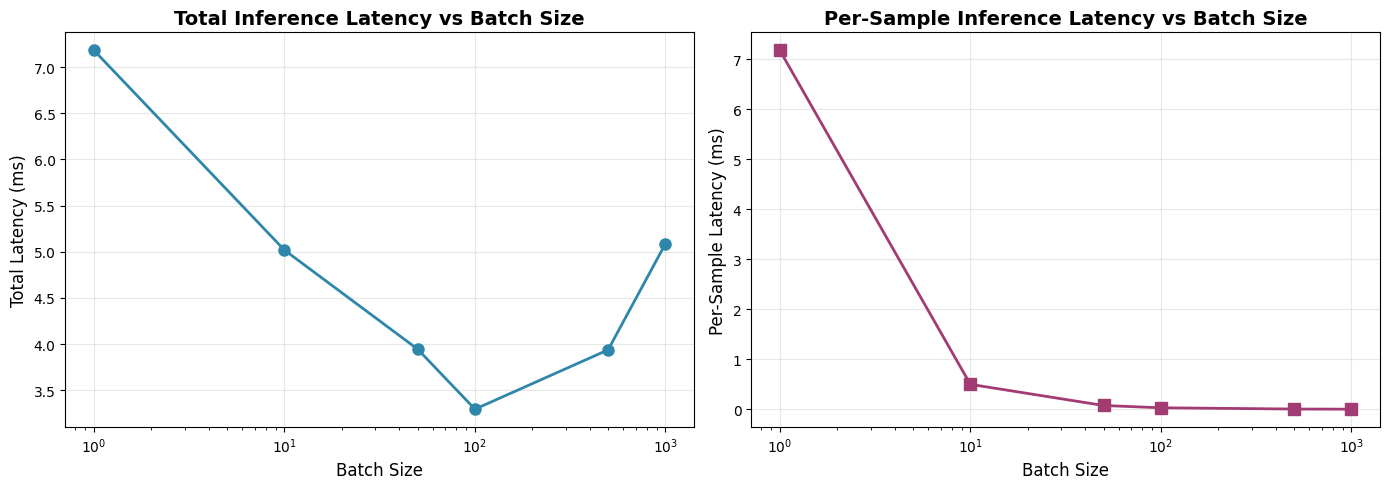


Latency Analysis:
Batch Size    1: Total =  7.183 ms, Per-Sample = 7.1826 ms
Batch Size   10: Total =  5.019 ms, Per-Sample = 0.5019 ms
Batch Size   50: Total =  3.946 ms, Per-Sample = 0.0789 ms
Batch Size  100: Total =  3.296 ms, Per-Sample = 0.0330 ms
Batch Size  500: Total =  3.938 ms, Per-Sample = 0.0079 ms
Batch Size 1000: Total =  5.089 ms, Per-Sample = 0.0051 ms


In [9]:
# Measure inference latency for different batch sizes
batch_sizes = [1, 10, 50, 100, 500, 1000]
latencies = []

for batch_size in batch_sizes:
    # Generate random samples
    random_samples = np.random.rand(batch_size, 4) * 3 + 4  # Scale to reasonable iris range
    
    # Measure inference time
    start_time = time.time()
    _ = model.predict(random_samples)
    end_time = time.time()
    
    latency_ms = (end_time - start_time) * 1000
    latencies.append(latency_ms)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Total latency vs batch size
axes[0].plot(batch_sizes, latencies, 'o-', linewidth=2, markersize=8, color='#2E86AB')
axes[0].set_xlabel('Batch Size', fontsize=12)
axes[0].set_ylabel('Total Latency (ms)', fontsize=12)
axes[0].set_title('Total Inference Latency vs Batch Size', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

# Plot 2: Per-sample latency vs batch size
per_sample_latencies = [lat / bs for lat, bs in zip(latencies, batch_sizes)]
axes[1].plot(batch_sizes, per_sample_latencies, 's-', linewidth=2, markersize=8, color='#A23B72')
axes[1].set_xlabel('Batch Size', fontsize=12)
axes[1].set_ylabel('Per-Sample Latency (ms)', fontsize=12)
axes[1].set_title('Per-Sample Inference Latency vs Batch Size', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig('inference_latency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLatency Analysis:")
for bs, lat, psl in zip(batch_sizes, latencies, per_sample_latencies):
    print(f"Batch Size {bs:4d}: Total = {lat:6.3f} ms, Per-Sample = {psl:6.4f} ms")

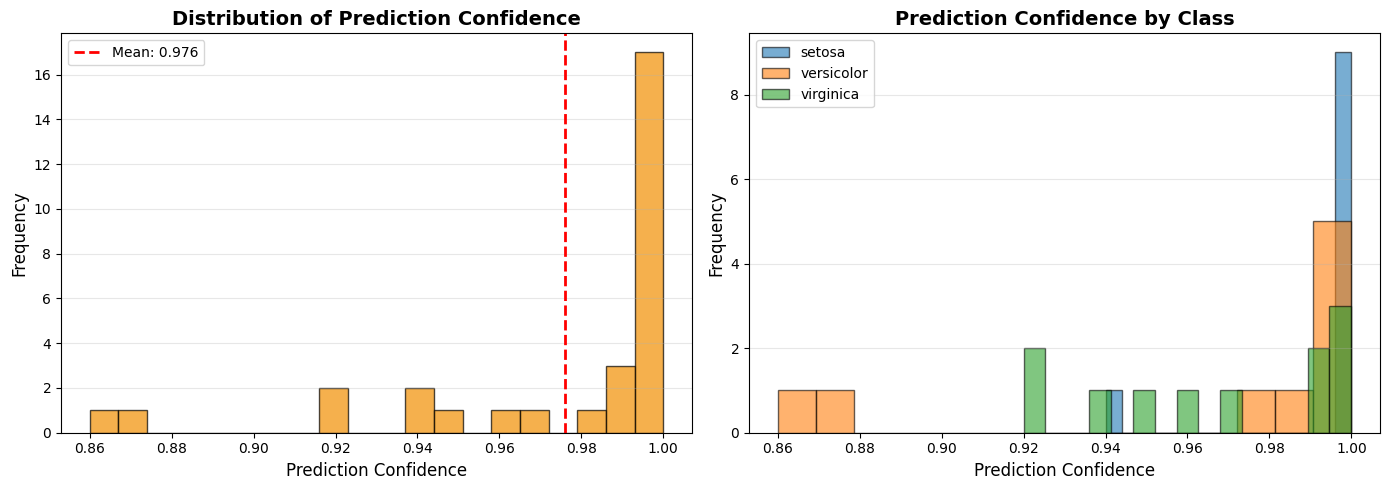


Confidence Statistics:
Mean confidence: 0.9760
Min confidence: 0.8600
Max confidence: 1.0000
Std confidence: 0.0387


In [10]:
# Visualize prediction confidence distribution
# Generate predictions on test set
test_probabilities = model.predict_proba(X_test)
test_confidences = np.max(test_probabilities, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confidence distribution
axes[0].hist(test_confidences, bins=20, edgecolor='black', alpha=0.7, color='#F18F01')
axes[0].axvline(test_confidences.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {test_confidences.mean():.3f}')
axes[0].set_xlabel('Prediction Confidence', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Prediction Confidence', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Confidence by class
for class_idx, class_name in enumerate(target_names):
    class_mask = y_test == class_idx
    class_confidences = test_confidences[class_mask]
    axes[1].hist(class_confidences, bins=15, alpha=0.6, label=class_name, edgecolor='black')

axes[1].set_xlabel('Prediction Confidence', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Prediction Confidence by Class', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('prediction_confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfidence Statistics:")
print(f"Mean confidence: {test_confidences.mean():.4f}")
print(f"Min confidence: {test_confidences.min():.4f}")
print(f"Max confidence: {test_confidences.max():.4f}")
print(f"Std confidence: {test_confidences.std():.4f}")

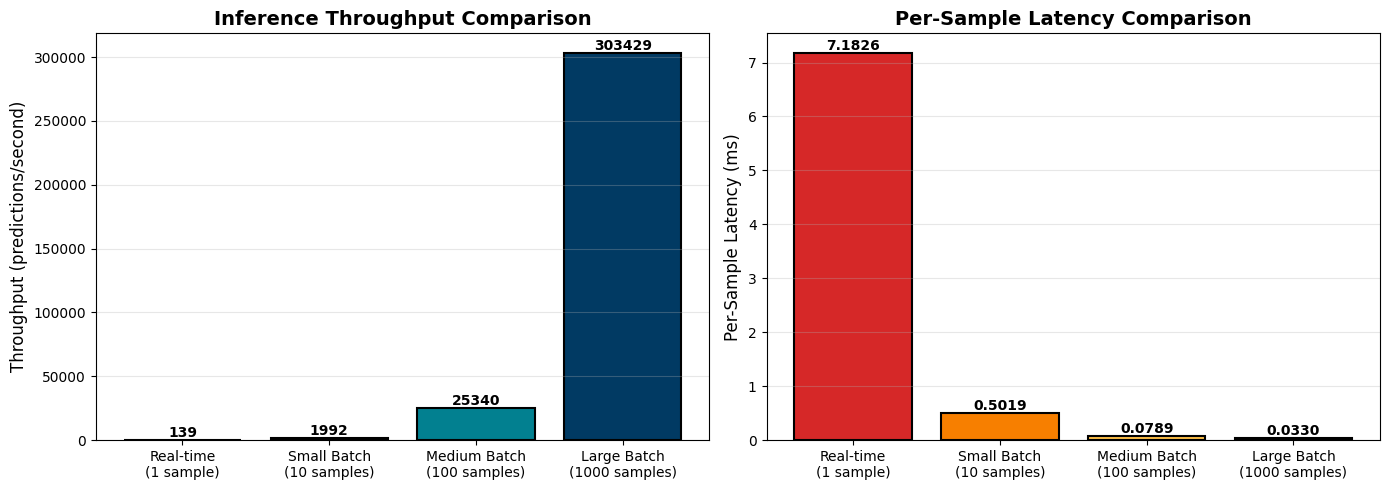


Batch vs Real-time Trade-offs:

Real-time Serving:
  ✓ Low latency per request
  ✓ Immediate responses
  ✗ Lower throughput
  ✗ Higher cost per prediction

Batch Serving:
  ✓ Higher throughput
  ✓ Lower cost per prediction
  ✗ Higher latency for individual samples
  ✗ Delayed responses


In [11]:
# Compare batch vs real-time serving trade-offs
scenarios = ['Real-time\n(1 sample)', 'Small Batch\n(10 samples)', 
             'Medium Batch\n(100 samples)', 'Large Batch\n(1000 samples)']
throughput = [1000/latencies[0], 10000/latencies[1], 100000/latencies[2], 1000000/latencies[3]]
latency_per_sample = [per_sample_latencies[0], per_sample_latencies[1], 
                       per_sample_latencies[2], per_sample_latencies[3]]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Throughput comparison
bars1 = axes[0].bar(scenarios, throughput, color=['#06A77D', '#05668D', '#028090', '#013A63'], 
                     edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Throughput (predictions/second)', fontsize=12)
axes[0].set_title('Inference Throughput Comparison', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Latency comparison
bars2 = axes[1].bar(scenarios, latency_per_sample, 
                     color=['#D62828', '#F77F00', '#FCBF49', '#EAE2B7'],
                     edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Per-Sample Latency (ms)', fontsize=12)
axes[1].set_title('Per-Sample Latency Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('batch_vs_realtime_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nBatch vs Real-time Trade-offs:")
print("\nReal-time Serving:")
print("  ✓ Low latency per request")
print("  ✓ Immediate responses")
print("  ✗ Lower throughput")
print("  ✗ Higher cost per prediction")
print("\nBatch Serving:")
print("  ✓ Higher throughput")
print("  ✓ Lower cost per prediction")
print("  ✗ Higher latency for individual samples")
print("  ✗ Delayed responses")

## Hands-on Activity: Build Your Own Model API

Now it's your turn! Complete the following exercises to reinforce your understanding of model serving.

### Exercise 1: Deploy Your Own Model

1. Train a different classifier (e.g., Logistic Regression, SVM) on the Iris dataset
2. Save the model using joblib
3. Modify either the Flask or FastAPI code to serve your model
4. Test the API with sample predictions

### Exercise 2: Add Input Validation

Enhance the API with robust input validation:
- Check that the number of features matches the expected input dimension
- Validate that feature values are within reasonable ranges
- Return informative error messages for invalid inputs

### Exercise 3: Add Logging and Monitoring

Add functionality to track:
- Number of predictions made
- Average prediction time
- Distribution of predicted classes
- Timestamp of each request

### Exercise 4: Performance Optimization

Experiment with different optimizations:
- Implement request batching for real-time API
- Add caching for frequently requested predictions
- Compare performance with and without optimizations

### Exercise 5: Model Versioning

Implement basic model versioning:
- Add a version number to your model metadata
- Create an endpoint that can serve multiple model versions
- Allow clients to specify which model version to use

### Challenge Exercise: Multi-Model Serving

Create an API that can serve multiple models:
- Train different models (Random Forest, SVM, Logistic Regression)
- Create endpoints that allow clients to choose which model to use
- Implement an ensemble endpoint that combines predictions from all models

In [12]:
# Starter code for Exercise 1
from sklearn.linear_model import LogisticRegression

# Your code here: Train a Logistic Regression model
# Hint: Use the same train/test split we created earlier

# TODO: Train the model
lr_model = LogisticRegression(max_iter=200, random_state=42)
# lr_model.fit(...)

# TODO: Evaluate the model
# ...

# TODO: Save the model
# joblib.dump(lr_model, 'logistic_regression_model.pkl')

print("Complete the exercise by training, evaluating, and saving your model!")

Complete the exercise by training, evaluating, and saving your model!


## Key Takeaways

Congratulations on completing Lesson 72! Here are the key concepts to remember:

1. **Model Serving is Critical**: Training a model is just the beginning; deploying it for real-world use is essential for delivering value.

2. **REST APIs Provide Standard Interface**: Flask and FastAPI enable you to expose ML models through standard HTTP endpoints that any application can consume.

3. **Batch vs Real-time Trade-offs**:
   - Real-time: Low latency, immediate responses, lower throughput
   - Batch: High throughput, efficient processing, higher per-sample latency

4. **Framework Comparison**:
   - **Flask**: Simple, lightweight, great for prototypes and simple APIs
   - **FastAPI**: Modern, automatic docs, type validation, async support, better for production

5. **Performance Considerations**:
   - Batching improves throughput significantly
   - Per-sample latency decreases with larger batch sizes
   - Choose serving strategy based on application requirements

6. **Production Best Practices**:
   - Implement health checks and monitoring
   - Add input validation and error handling
   - Version your models and APIs
   - Log predictions for debugging and monitoring
   - Consider caching for frequently requested predictions

7. **API Design Principles**:
   - Keep endpoints stateless
   - Return informative error messages
   - Include confidence scores with predictions
   - Provide metadata about the model

8. **Scalability**: Model serving infrastructure should handle varying loads, support horizontal scaling, and maintain low latency under load.

## Additional Resources

To deepen your understanding of model serving and deployment, explore these resources:

### Documentation
- [Flask Documentation](https://flask.palletsprojects.com/)
- [FastAPI Documentation](https://fastapi.tiangolo.com/)
- [Scikit-learn Model Persistence](https://scikit-learn.org/stable/model_persistence.html)

### Advanced Topics
- [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving): Production-ready serving system for TensorFlow models
- [TorchServe](https://pytorch.org/serve/): PyTorch model serving framework
- [MLflow Models](https://mlflow.org/docs/latest/models.html): Unified model packaging and deployment
- [BentoML](https://docs.bentoml.org/): Unified model serving framework
- [Seldon Core](https://www.seldon.io/): Kubernetes-native model deployment

### Books
- "Building Machine Learning Powered Applications" by Emmanuel Ameisen
- "Machine Learning Design Patterns" by Valliappa Lakshmanan et al.
- "Designing Machine Learning Systems" by Chip Huyen

### Best Practices
- [Google Cloud ML Best Practices](https://cloud.google.com/architecture/mlops-continuous-delivery-and-automation-pipelines-in-machine-learning)
- [AWS SageMaker Deployment Best Practices](https://docs.aws.amazon.com/sagemaker/latest/dg/best-practices.html)
- [Azure ML Deployment Guide](https://learn.microsoft.com/en-us/azure/machine-learning/)

### Next Steps
- **Lesson 73**: Model Monitoring and Performance Tracking
- **Lesson 74**: CI/CD for Machine Learning Pipelines
- **Lesson 75**: Experiment Tracking and Model Versioning

---

## Summary

In this lesson, you learned how to deploy machine learning models as REST APIs using Flask and FastAPI. You explored the differences between batch and real-time inference, analyzed performance trade-offs, and learned best practices for production model serving. These skills are essential for transforming your ML models from experiments into production systems that deliver real value.

Continue practicing by deploying your own models and experimenting with different serving strategies!

**Happy Learning! 🚀**